In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.width', 780)

In [2]:
MNIST = keras.datasets.mnist
(X_images,X_labels),(y_images,y_lables) = MNIST.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
X_images = X_images.astype('float32') / 255.0
y_images = y_images.astype('float32') / 255.0

# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_images, X_labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [12]:
import kerastuner as kt

def build_model(hp):
    model = Sequential([
        Conv2D(filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
               kernel_size=hp.Choice('conv1_kernel_size', values=[3, 5]),
               activation='relu',
               input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=hp.Choice('pool_size', values=[2, 3])),
        Conv2D(filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
               kernel_size=hp.Choice('conv2_kernel_size', values=[3, 5]),
               activation='relu'),
        MaxPooling2D(pool_size=hp.Choice('pool_size', values=[2, 3])),
        Flatten(),
        Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
              activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     hyperband_iterations=2,
                     directory='my_dir',
                     project_name='mnist')


In [13]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

Trial 32 Complete [00h 06m 46s]
val_accuracy: 0.9594791531562805

Best val_accuracy So Far: 0.9911458492279053
Total elapsed time: 02h 27m 09s

Search: Running Trial #33

Value             |Best Value So Far |Hyperparameter
64                |32                |conv1_filters
5                 |5                 |conv1_kernel_size
2                 |3                 |pool_size
64                |128               |conv2_filters
5                 |3                 |conv2_kernel_size
96                |96                |dense_units
sgd               |adam              |optimizer
2                 |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
2                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/2
 336/1200 ━━━━━━━━━━━━━━━━━━━━ 50s 59ms/step - accuracy: 0.4911 - loss: 1.8603

KeyboardInterrupt: 

In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.get_best_models(num_models=1)[0]

eval_result = best_model.evaluate(X_test, y_test)
print(f"Test loss: {eval_result[0]}")
print(f"Test accuracy: {eval_result[1]}")


Best hyperparameters: {'conv1_filters': 32, 'conv1_kernel_size': 5, 'pool_size': 3, 'conv2_filters': 128, 'conv2_kernel_size': 3, 'dense_units': 96, 'optimizer': 'adam', 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9898 - loss: 0.0373
Test loss: 0.03582315519452095
Test accuracy: 0.9902499914169312


Epoch 1/4
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9972 - loss: 0.0092 - val_accuracy: 0.9906 - val_loss: 0.0356
Epoch 2/4
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.9958 - loss: 0.0117 - val_accuracy: 0.9892 - val_loss: 0.0440
Epoch 3/4
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9980 - loss: 0.0062 - val_accuracy: 0.9896 - val_loss: 0.0408
Epoch 4/4
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.9978 - loss: 0.0064 - val_accuracy: 0.9901 - val_loss: 0.0382


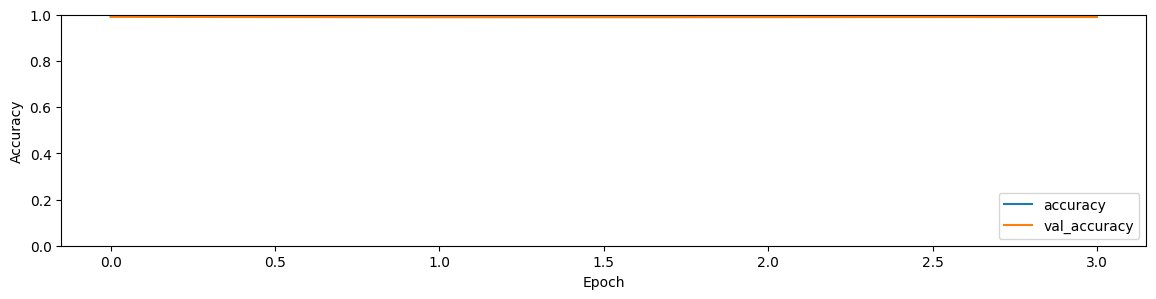

In [22]:
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=4, verbose=1)
plt.figure(figsize=(14, 3))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


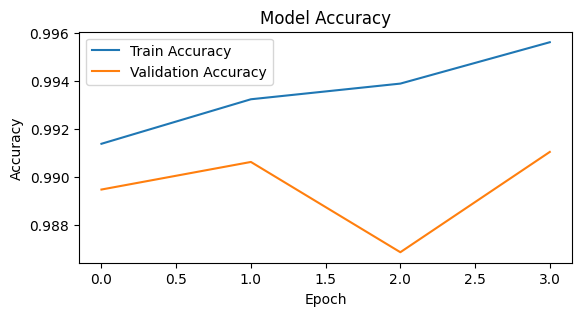

In [20]:
plt.figure(figsize=(14, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

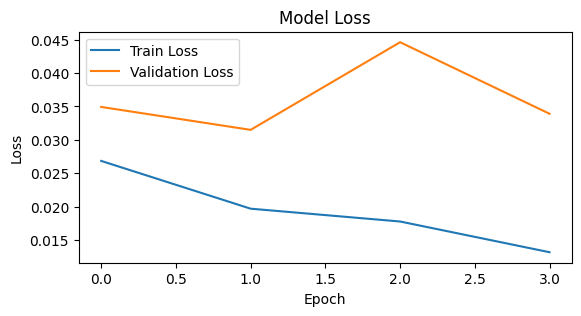

In [21]:
plt.figure(figsize=(14, 3))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


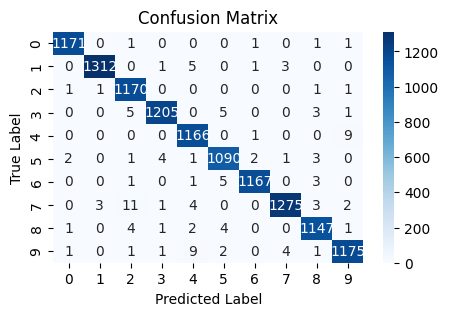

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = best_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [26]:
class_report = classification_report(y_test_classes, y_pred_classes, target_names=[str(i) for i in range(10)])
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1175
           1       1.00      0.99      0.99      1322
           2       0.98      1.00      0.99      1174
           3       0.99      0.99      0.99      1219
           4       0.98      0.99      0.99      1176
           5       0.99      0.99      0.99      1104
           6       1.00      0.99      0.99      1177
           7       0.99      0.98      0.99      1299
           8       0.99      0.99      0.99      1160
           9       0.99      0.98      0.99      1194

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000

